# Predictions without kernel normalisation

**NOTES**
Copy from Compare_with_baseline.ipynb
change 113-117 lines of kernels_for_GPK.py to use raw kernel without normalisation
TODO: Need to add one parameter to control it.  
I also deleted all baseline predictions since they are not influenced by the change.


Update 29/Oct/2020  
We now have Round 1's results. We observe that the consensus sequence has very different labels for different plates/rounds. So we decide to normalise to the consensus sequence (before log normalisation and z-normalisation, subtract the mean of each consensus sequence mean in each plate/round). We will call the normalisation methods as **plate normalisation** and **round normalisation** respectively.
Let's see how the predictions look like for different normalisation methods on the following training/testing pairs
- train 80% round 0 and test 20% round 0
- train round 0 and test round 1
- train 80% all data (round 0 + 1) and test the rest

Our model GPR with wd kernel with shift.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

import pickle
import xarray

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Read Data and Set Up

In [2]:
# plate normalisation
plateRep_Path = '../../data/Results_Microplate_partialFalse_normTrue_plateRep_formatSeq_logTrue.csv'
# round normalisation
roundRep_Path = '../../data/Results_Microplate_partialFalse_normTrue_roundRep_formatSeq_logTrue.csv'

plate_df = pd.read_csv(plateRep_Path)
round_df = pd.read_csv(roundRep_Path)

In [3]:
def run_kfold(df,kernel, embedding, train_idx = None, test_idx = None, 
              num_split = 5,num_repeat = 10,s_list = [1],alpha_list= [2],l_list = [6]):
    gpr = GPR_Predictor(df, train_idx = train_idx, test_idx = test_idx, embedding = embedding, kernel_name = kernel)
    result_DataArray_wd = gpr.Repeated_kfold(num_split=num_split, num_repeat=num_repeat, alpha_list= alpha_list,
                                          l_list = l_list, s_list = s_list)
    # print(result_DataArray_wd[1].mean(axis = -1).mean(axis=-1))
    return result_DataArray_wd

def run_regression(df,kernel, embedding, train_idx = None, test_idx = None, 
               eva_metric = [mean_squared_error, r2_score], l = 6, s = 1, alpha = 2, eva_on='seqs', title = 'Prediction'):
    # train and test on round 0
    gpr_train_samples = GPR_Predictor(df, train_idx= train_idx, test_idx=test_idx, kernel_name = kernel, embedding = embedding,     
                                    eva_metric = eva_metric, l = l, s = s, alpha = alpha, eva_on=eva_on)
    gpr_train_samples.regression()
    gpr_train_samples.scatter_plot(title = title)


## Train and Test on Round 0

X train shape:  (851, 20)
X test shape:  (35, 20)
create kernel instance
USE non-normalised kernel!
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7fd4a6965488>
Train:  0.2667145443036681
Test:  0.8823504857293554
<function r2_score at 0x7fd4a69656a8>
Train:  0.6695813754248965
Test:  0.17803998640905572


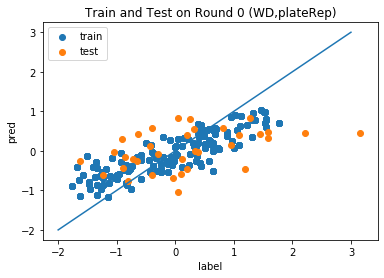

X train shape:  (851, 20)
X test shape:  (35, 20)
create kernel instance
USE non-normalised kernel!
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7fd4a6965488>
Train:  0.24368848914431626
Test:  0.6769976326335523
<function r2_score at 0x7fd4a69656a8>
Train:  0.7048614063627496
Test:  0.33032666035271474


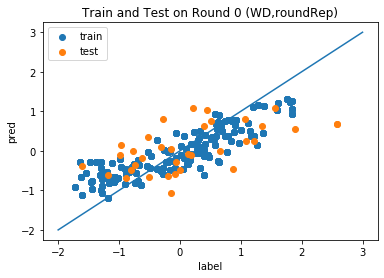

In [4]:
# setting

kernel = 'WD_Kernel_Shift' # 'RBF'
embedding = 'label' # 'onehot'

run_regression(plate_df[plate_df['Plate'] != 'Third_Plate'], kernel, embedding, title = 'Train and Test on Round 0 (WD,plateRep)')
run_regression(round_df[round_df['Plate'] != 'Third_Plate'], kernel, embedding, title = 'Train and Test on Round 0 (WD,roundRep)')

# kernel = 'RBF'
# embedding = 'onehot'

# run_regression(plate_df[plate_df['Plate'] != 'Third_Plate'], kernel, embedding, title = 'Train and Test on Round 0 (RBF,plateRep)')
# run_regression(round_df[round_df['Plate'] != 'Third_Plate'], kernel, embedding, title = 'Train and Test on Round 0 (RBF,roundRep)')

## Train on Round 0 and Test on Round 1

X train shape:  (1061, 20)
X test shape:  (89, 20)
create kernel instance
USE non-normalised kernel!
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7fd4a6965488>
Train:  0.3392453923937184
Test:  0.8381434276408773
<function r2_score at 0x7fd4a69656a8>
Train:  0.6092069183197493
Test:  0.031116364680325415


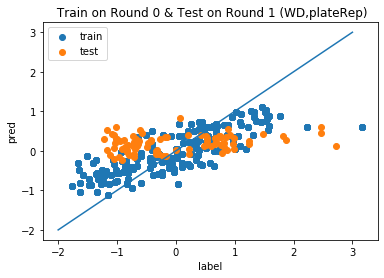

X train shape:  (1061, 20)
X test shape:  (89, 20)
create kernel instance
USE non-normalised kernel!
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7fd4a6965488>
Train:  0.28968033450154484
Test:  0.8002314495155459
<function r2_score at 0x7fd4a69656a8>
Train:  0.6668389029342373
Test:  0.07494215150492833


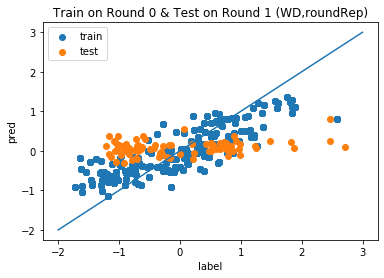

In [5]:
# setting
kernel = 'WD_Kernel_Shift' # 'RBF'
embedding = 'label' # 'onehot'

run_regression(plate_df, kernel, embedding, train_idx= plate_df['Plate'] != 'Third_Plate', 
                test_idx= plate_df['Plate'] == 'Third_Plate', title = ' Train on Round 0 & Test on Round 1 (WD,plateRep)')
run_regression(round_df, kernel, embedding, train_idx= round_df['Plate'] != 'Third_Plate', 
                test_idx= round_df['Plate'] == 'Third_Plate',  title = 'Train on Round 0 & Test on Round 1 (WD,roundRep)')

# kernel = 'RBF'
# embedding = 'onehot'

# run_regression(plate_df, kernel, embedding, train_idx= plate_df['Plate'] != 'Third_Plate', 
#                 test_idx= plate_df['Plate'] == 'Third_Plate', title = ' Train on Round 0 & Test on Round 1 (RBF,plateRep)')
# run_regression(round_df, kernel, embedding, train_idx= round_df['Plate'] != 'Third_Plate', 
#                 test_idx= round_df['Plate'] == 'Third_Plate',  title = 'Train on Round 0 & Test on Round 1 (RBF,roundRep)')

## Train and Test on All Rounds Data

X train shape:  (1276, 20)
X test shape:  (53, 20)
create kernel instance
USE non-normalised kernel!
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7fd4a6965488>
Train:  0.417397077549952
Test:  0.5411791460189996
<function r2_score at 0x7fd4a69656a8>
Train:  0.5315939313220628
Test:  0.2716794596223634


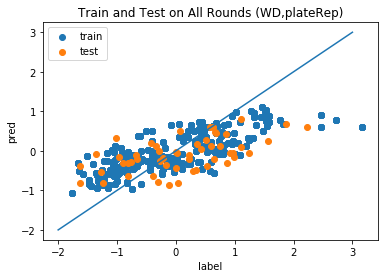

X train shape:  (1276, 20)
X test shape:  (53, 20)
create kernel instance
USE non-normalised kernel!
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7fd4a6965488>
Train:  0.37352895193924524
Test:  0.4999324936267345
<function r2_score at 0x7fd4a69656a8>
Train:  0.5794425672163777
Test:  0.3442190670704327


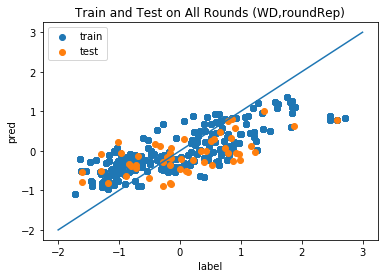

In [6]:
# setting
kernel = 'WD_Kernel_Shift' # 'RBF'
embedding = 'label' # 'onehot'

run_regression(plate_df, kernel, embedding, title = 'Train and Test on All Rounds (WD,plateRep)')
run_regression(round_df, kernel, embedding, title = 'Train and Test on All Rounds (WD,roundRep)')

# kernel = 'RBF'
# embedding = 'onehot'

# run_regression(plate_df, kernel, embedding, title = 'Train and Test on All Rounds (RBF,plateRep)')
# run_regression(round_df, kernel, embedding, title = 'Train and Test on All Rounds (RBF,roundRep)')